In this assignment you'll have to explore and classify time series. The dataset is [FordA](http://www.timeseriesclassification.com/description.php?Dataset=FordA), which is a set of recordings of engine noise under typical conditions and you need to classify if certain condition exists.

In [89]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

Populating the interactive namespace from numpy and matplotlib


c:\Users\itay8\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['sample', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [90]:
# Plotting improts
import seaborn as sns

In [91]:
# Generic imports
import pathlib
import matplotlib.pyplot as plt
# DS imports
import scipy.stats as stats
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report

## Constants

In [92]:
DATA_DIR = pathlib.Path("DordA/")
DATASET = ""

# Loading the data

Data files are stored in tabular format:

In [93]:
!head -n 2 data/FordA/FordA_TRAIN.txt

'head' is not recognized as an internal or external command,
operable program or batch file.


In [94]:
train = pd.read_csv("./FordA/FordA_TRAIN.txt",
                    header=None,
                    sep="\s+",
                    skipinitialspace=True)
test = pd.read_csv("./FordA/FordA_TEST.txt",
                   header=None,
                   sep="\s+",
                   skipinitialspace=True)

In [95]:
train.head()

0         1         2         3         4         5         6         7    \
0 -1.0 -0.797172 -0.664392 -0.373015  0.040815  0.526936  0.984288  1.353120   
1  1.0  0.804855  0.634629  0.373474  0.038343 -0.340988 -0.740860 -1.109667   
2 -1.0  0.727985  0.111284 -0.499124 -1.068629 -1.578351 -1.990534 -2.302031   
3 -1.0 -0.234439 -0.502157 -0.732488 -0.946128 -1.139739 -1.323336 -1.490243   
4 -1.0 -0.171328 -0.062285  0.235829  0.710396  1.239969  1.649823  1.876321   

        8         9    ...       491       492       493       494       495  \
0  1.578108  1.659251  ...  1.120756  0.722417  0.362068  0.092083 -0.081268   
1 -1.395357 -1.570192  ...  0.386403  0.049213 -0.258138 -0.510583 -0.683647   
2 -2.503403 -2.585211  ...  0.394463  0.463685  0.507735  0.517174  0.504588   
3 -1.607077 -1.620430  ... -0.952804 -0.929437 -0.922761 -0.929437 -0.909409   
4  1.865535  1.703751  ...  0.776188  0.725496  0.697453  0.731967  0.808545   

        496       497       498       499       500  
0 -0.212573 -0.391456 -0.664392 -1.073796 -1.564343  
1 -0.773817 -0.785255 -0.714885 -0.560443 -0.319086  
2  0.476270  0.438513  0.394463  0.339400  0.255391  
3 -0.835970 -0.695768 -0.478790 -0.188707  0.119736  
4  0.839823  0.733046  0.437520 -0.026585 -0.602213  

[5 rows x 501 columns]

So, each row represents a single measurement, with column `0` being class label, and columns `1-501` being measured values. Let's check missing values:

In [96]:
train.notnull().sum(axis=1).unique()

array([501], dtype=int64)

In [97]:
test.notnull().sum(axis=1).unique()

array([501], dtype=int64)

Let's change column names to something meaningful:

In [98]:
train.rename({0: "label"}, axis=1, inplace=True)
test.rename({0: "label"}, axis=1, inplace=True)

In [99]:
train.rename({cl: f"val_{cl}" for cl in range(1, 501)}, axis=1, inplace=True)
test.rename({cl: f"val_{cl}" for cl in range(1, 501)}, axis=1, inplace=True)

We can now select data values by filtering:

In [100]:
train.filter(like="val_")

val_1     val_2     val_3     val_4     val_5     val_6     val_7  \
0    -0.797172 -0.664392 -0.373015  0.040815  0.526936  0.984288  1.353120   
1     0.804855  0.634629  0.373474  0.038343 -0.340988 -0.740860 -1.109667   
2     0.727985  0.111284 -0.499124 -1.068629 -1.578351 -1.990534 -2.302031   
3    -0.234439 -0.502157 -0.732488 -0.946128 -1.139739 -1.323336 -1.490243   
4    -0.171328 -0.062285  0.235829  0.710396  1.239969  1.649823  1.876321   
...        ...       ...       ...       ...       ...       ...       ...   
3596  0.196022 -0.070102 -0.336226 -0.516799 -0.555282 -0.442793 -0.221369   
3597  0.041994  0.422255  0.740529  0.975426  1.109891  1.137270  1.058349   
3598 -0.570054 -0.333165 -0.293519 -0.425344 -0.590869 -0.615648 -0.348033   
3599  2.006732  2.079150  2.022036  1.867560  1.648112  1.379446  1.093717   
3600 -0.125241 -0.325363 -0.488237 -0.599045 -0.651111 -0.647106 -0.595040   

         val_8     val_9    val_10  ...   val_491   val_492   val_493  \
0     1.578108  1.659251  1.640809  ...  1.120756  0.722417  0.362068   
1    -1.395357 -1.570192 -1.619951  ...  0.386403  0.049213 -0.258138   
2    -2.503403 -2.585211 -2.550600  ...  0.394463  0.463685  0.507735   
3    -1.607077 -1.620430 -1.506933  ... -0.952804 -0.929437 -0.922761   
4     1.865535  1.703751  1.466467  ...  0.776188  0.725496  0.697453   
...        ...       ...       ...  ...       ...       ...       ...   
3596  0.025217  0.233320  0.350545  ...  1.715205  1.129082  0.528158   
3597  0.894955  0.671224  0.421544  ... -0.463329 -0.392667 -0.333749   
3598  0.275412  1.153586  2.035725  ...  0.902821  0.579700  0.157463   
3599  0.784057  0.434150  0.029284  ...  1.268671  1.148971  0.928088   
3600 -0.502922 -0.388109 -0.259946  ...  0.005352  0.157920  0.288753   

       val_494   val_495   val_496   val_497   val_498   val_499   val_500  
0     0.092083 -0.081268 -0.212573 -0.391456 -0.664392 -1.073796 -1.564343  
1    -0.510583 -0.683647 -0.773817 -0.785255 -0.714885 -0.560443 -0.319086  
2     0.517174  0.504588  0.476270  0.438513  0.394463  0.339400  0.255391  
3    -0.929437 -0.909409 -0.835970 -0.695768 -0.478790 -0.188707  0.119736  
4     0.731967  0.808545  0.839823  0.733046  0.437520 -0.026585 -0.602213  
...        ...       ...       ...       ...       ...       ...       ...  
3596 -0.039020 -0.573043 -1.061479 -1.514392 -1.934743 -2.316612 -2.603753  
3597 -0.316543 -0.340299 -0.392876 -0.450805 -0.482609 -0.467769 -0.393755  
3598 -0.353980 -0.885246 -1.314421 -1.512655 -1.393714 -0.942733 -0.270722  
3599  0.634953  0.311682 -0.007376 -0.270543 -0.432145 -0.441231 -0.280709  
3600  0.384876  0.451628  0.497019  0.527725  0.555761  0.574451  0.573116  

[3601 rows x 500 columns]

The dataset is almost balanced:

In [101]:
train.iloc[:, 0].value_counts()

-1.0    1846
 1.0    1755
Name: label, dtype: int64

In [102]:
test.iloc[:, 0].value_counts()

-1.0    681
 1.0    639
Name: label, dtype: int64

# Task 1: explore time series

In this task you need to plot data samples with class label designation. Consider 10 or 20 random samples, and create a `2 x 5` or `4 x 5` plot, with eash subplot being the data records (i. e. `train.filter(like="val_").iloc[<sample_idx>]`), subtitles displaying sample index and class label. You can use color as well.

In [103]:
N_SAMPLES = 20
N_COLS = 5
N_ROWS = 20 // N_COLS

samples = train.sample(N_SAMPLES, replace=False)

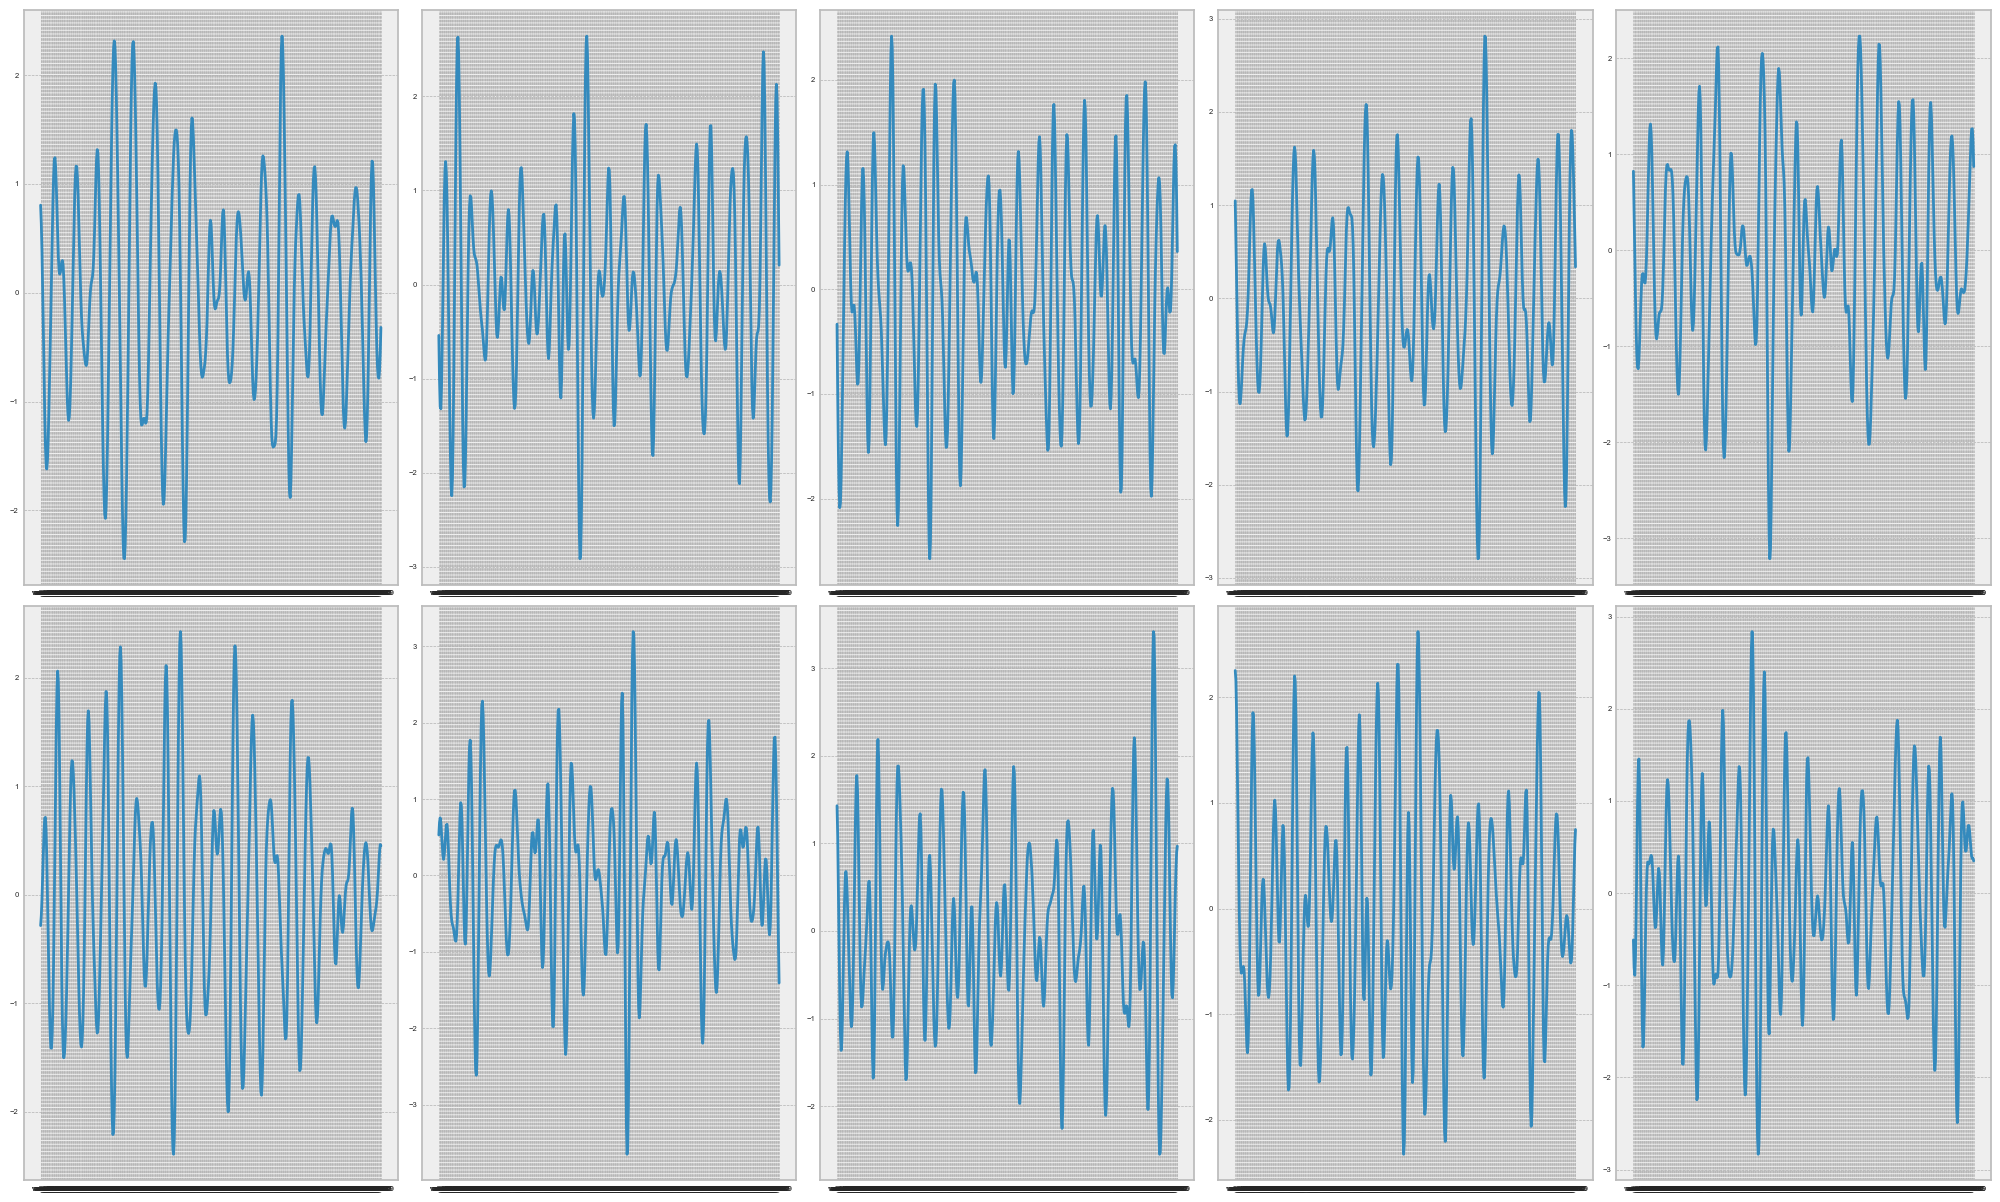

In [104]:
N_SAMPLES = 10
N_COLS = 5
N_ROWS = N_SAMPLES // N_COLS

samples = train.sample(N_SAMPLES, replace=False)
plt.figure( figsize=(20,12) )

for si, (sidx, sample) in enumerate(samples.iterrows()):
    plt.subplot(N_ROWS,N_COLS,si+1)
    plt.plot(train.loc[train["label"]==1,].filter(like="val_").iloc[si])

plt.tight_layout();


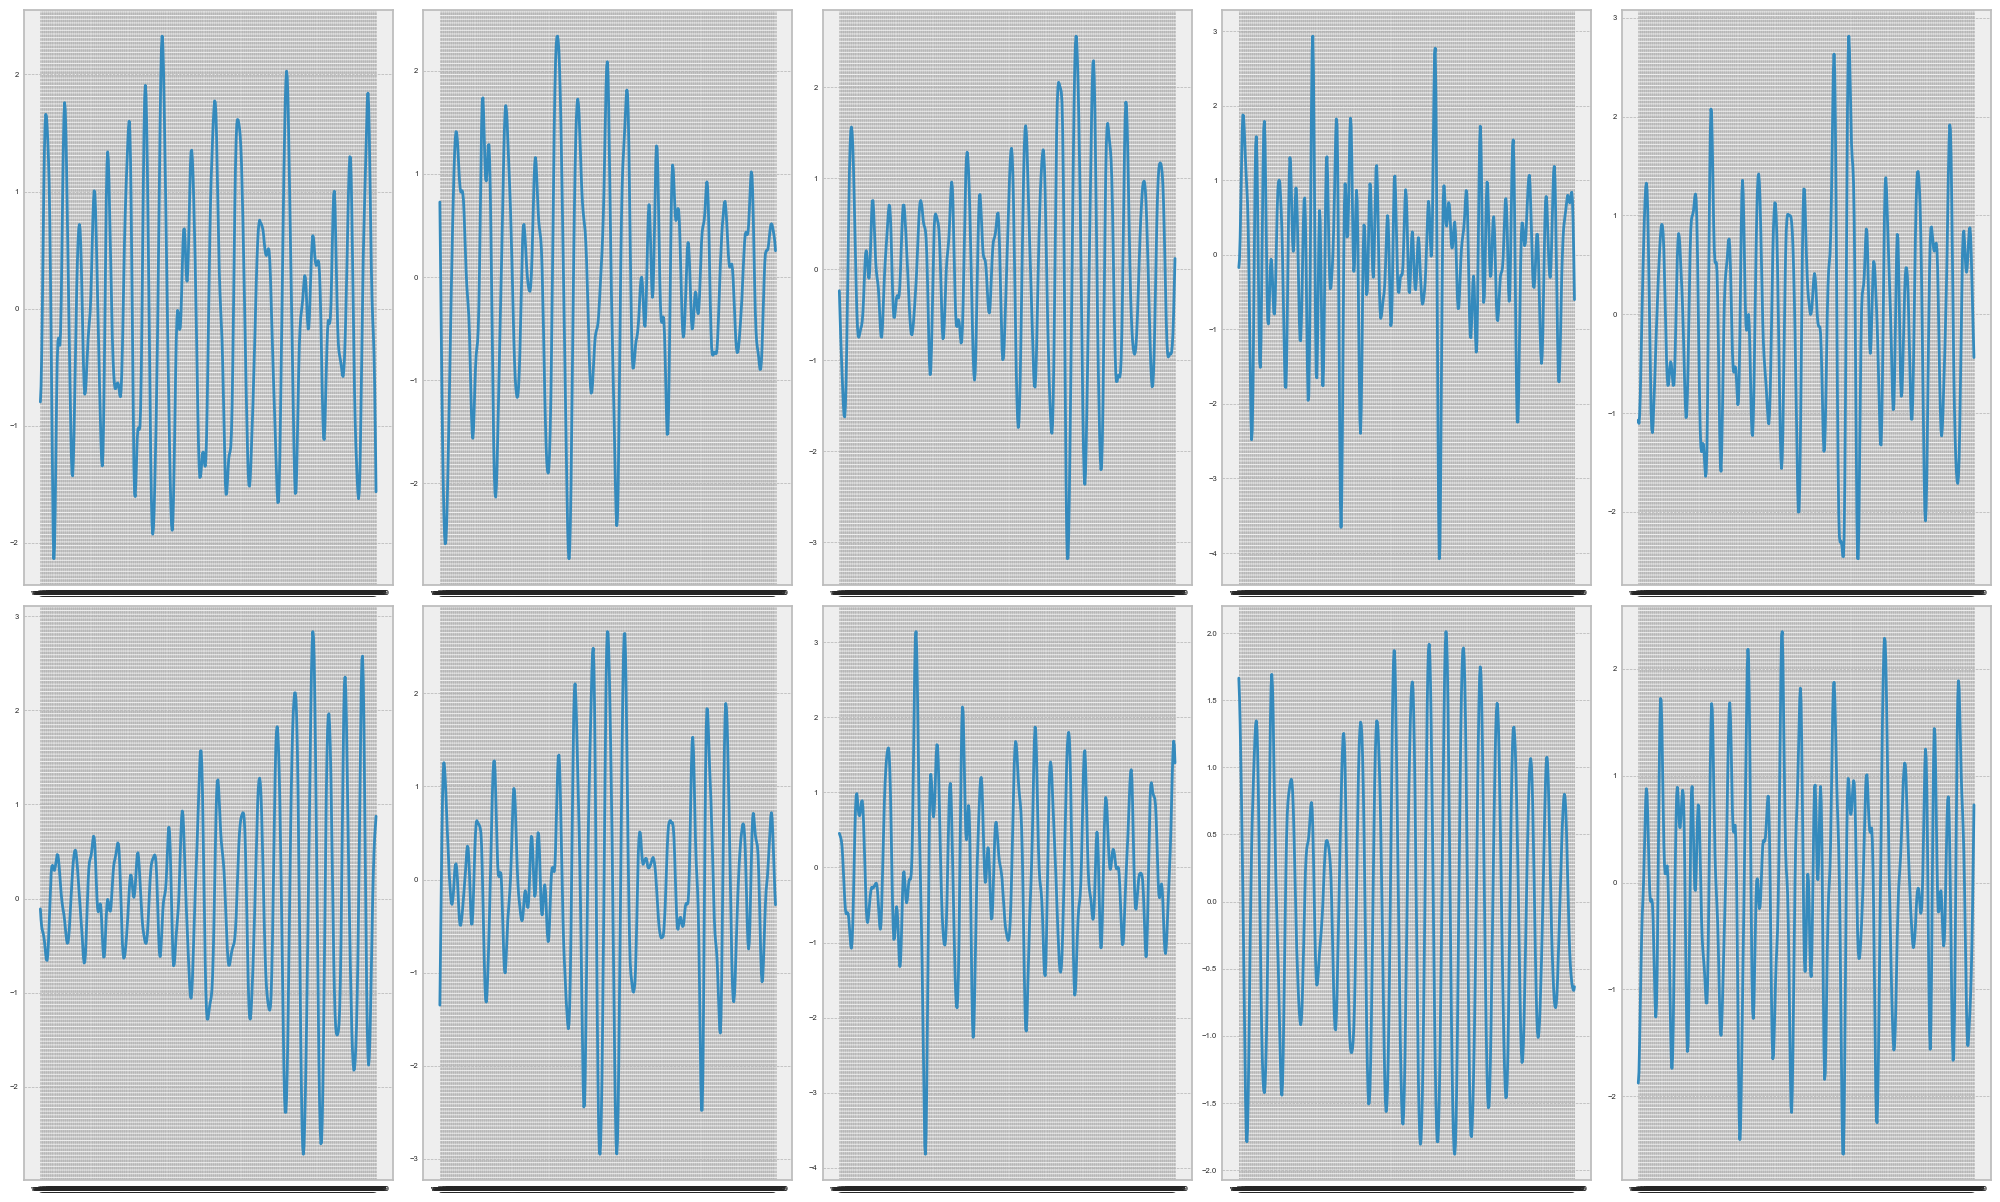

In [105]:
N_SAMPLES = 10
N_COLS = 5
N_ROWS = N_SAMPLES // N_COLS

samples = train.sample(N_SAMPLES, replace=False)
plt.figure( figsize=(20,12) )

for si, (sidx, sample) in enumerate(samples.iterrows()):
    plt.subplot(N_ROWS,N_COLS,si+1)
    plt.plot(train.loc[train["label"]==-1,].filter(like="val_").iloc[si])

plt.tight_layout();


In [ ]:
# df['pattern'] = (df.groupby(['id', df['value'].diff().ne(0).cumsum()])
#                    ['id'].transform('size').ge(3).astype(int)
#                 )

In [198]:
idxs

[Int64Index([1106], dtype='int64'),
 Int64Index([2849], dtype='int64'),
 Int64Index([3306], dtype='int64'),
 Int64Index([52], dtype='int64'),
 Int64Index([2207], dtype='int64'),
 Int64Index([859], dtype='int64'),
 Int64Index([1622], dtype='int64'),
 Int64Index([698], dtype='int64'),
 Int64Index([3587], dtype='int64'),
 Int64Index([3587], dtype='int64'),
 Int64Index([820], dtype='int64'),
 Int64Index([954], dtype='int64'),
 Int64Index([3066], dtype='int64'),
 Int64Index([475], dtype='int64'),
 Int64Index([2085], dtype='int64'),
 Int64Index([3029], dtype='int64'),
 Int64Index([3439], dtype='int64'),
 Int64Index([875], dtype='int64'),
 Int64Index([875], dtype='int64'),
 Int64Index([11], dtype='int64'),
 Int64Index([3390], dtype='int64'),
 Int64Index([1097, 1899], dtype='int64'),
 Int64Index([2877], dtype='int64'),
 Int64Index([259], dtype='int64'),
 Int64Index([863], dtype='int64'),
 Int64Index([863], dtype='int64'),
 Int64Index([13], dtype='int64'),
 Int64Index([3293], dtype='int64'),
 I

In [204]:
idxs = []
for i in range(1,496):
    clean = train[(train['val_' +str(i)] == train['val_' +str(i+1)])].index
    if len(clean > 0):
        idxs.append(clean)
    # index_3 = (train['val_' +str(i)] == train['val_' +str(i+3)]).index
    # index_4 = (train['val_' +str(i)] == train['val_' +str(i+4)]).index
    # index_5 = (train['val_' +str(i)] == train['val_' +str(i+5)]).index

flat_list = list()

for sub_list in idxs:
    for v in sub_list.values:
        flat_list.append(v)
uq_idx = np.unique(flat_list)


In [217]:
uq_idx.shape

(1617,)

In [213]:
df_rep_2 = train.loc[uq_idx].copy()
df_rep_2

label     val_1     val_2     val_3     val_4     val_5     val_6  \
0      -1.0 -0.797172 -0.664392 -0.373015  0.040815  0.526936  0.984288   
2      -1.0  0.727985  0.111284 -0.499124 -1.068629 -1.578351 -1.990534   
3      -1.0 -0.234439 -0.502157 -0.732488 -0.946128 -1.139739 -1.323336   
4      -1.0 -0.171328 -0.062285  0.235829  0.710396  1.239969  1.649823   
11     -1.0 -1.071044 -1.104749 -1.024700 -0.814043 -0.510696 -0.161427   
...     ...       ...       ...       ...       ...       ...       ...   
3589   -1.0  0.510523  0.582996  0.709824  0.895536  1.063129  1.158250   
3592   -1.0 -0.817429 -0.810198 -0.755966 -0.651117 -0.506498 -0.327894   
3596   -1.0  0.196022 -0.070102 -0.336226 -0.516799 -0.555282 -0.442793   
3598   -1.0 -0.570054 -0.333165 -0.293519 -0.425344 -0.590869 -0.615648   
3600   -1.0 -0.125241 -0.325363 -0.488237 -0.599045 -0.651111 -0.647106   

         val_7     val_8     val_9  ...   val_497   val_498   val_499  \
0     1.353120  1.578108  1.659251  ... -0.391456 -0.664392 -1.073796   
2    -2.302031 -2.503403 -2.585211  ...  0.438513  0.394463  0.339400   
3    -1.490243 -1.607077 -1.620430  ... -0.695768 -0.478790 -0.188707   
4     1.876321  1.865535  1.703751  ...  0.733046  0.437520 -0.026585   
11    0.168040  0.466752  0.727967  ...  0.344992  0.060605 -0.206929   
...        ...       ...       ...  ...       ...       ...       ...   
3589  1.117484  0.927243  0.573937  ... -0.036194 -0.187028 -0.165739   
3592 -0.129043  0.073785  0.265406  ... -0.195206 -0.017071  0.160918   
3596 -0.221369  0.025217  0.233320  ... -1.514392 -1.934743 -2.316612   
3598 -0.348033  0.275412  1.153586  ... -1.512655 -1.393714 -0.942733   
3600 -0.595040 -0.502922 -0.388109  ...  0.527725  0.555761  0.574451   

       val_500  data_median     data_mean  data_std  data_skew  data_max  \
0    -1.564343    -0.030960 -5.662000e-10  0.999000   0.076155  2.326837   
2     0.255391     0.076201 -2.378580e-09  0.998999  -0.278253  2.335813   
3     0.119736     0.011714  9.427800e-10  0.999000  -0.087142  2.562245   
4    -0.602213     0.092380 -4.188000e-10  0.999000  -0.632179  2.933311   
11   -0.438230     0.084199 -1.435200e-09  0.998999  -0.094716  2.813471   
...        ...          ...           ...       ...        ...       ...   
3589  0.010596     0.009419  6.926400e-10  0.999000   0.027802  2.304228   
3592  0.325422    -0.009027 -3.898800e-10  0.998999   0.018941  2.125567   
3596 -2.603753     0.010031 -9.364000e-11  0.998999  -0.140238  3.044343   
3598 -0.270722     0.052548  2.118000e-10  0.998999  -0.225336  2.600691   
3600  0.573116    -0.030453 -2.507740e-09  0.998999   0.024203  2.203194   

      data_min  
0    -2.136033  
2    -2.729947  
3    -3.179336  
4    -4.077337  
11   -2.474020  
...        ...  
3589 -2.261565  
3592 -2.158770  
3596 -3.764158  
3598 -3.048964  
3600 -2.108970  

[1617 rows x 507 columns]

In [210]:
df_rep_2[df_rep_2.label == -1]

label     val_1     val_2     val_3     val_4     val_5     val_6  \
0      -1.0 -0.797172 -0.664392 -0.373015  0.040815  0.526936  0.984288   
2      -1.0  0.727985  0.111284 -0.499124 -1.068629 -1.578351 -1.990534   
3      -1.0 -0.234439 -0.502157 -0.732488 -0.946128 -1.139739 -1.323336   
4      -1.0 -0.171328 -0.062285  0.235829  0.710396  1.239969  1.649823   
11     -1.0 -1.071044 -1.104749 -1.024700 -0.814043 -0.510696 -0.161427   
...     ...       ...       ...       ...       ...       ...       ...   
3589   -1.0  0.510523  0.582996  0.709824  0.895536  1.063129  1.158250   
3592   -1.0 -0.817429 -0.810198 -0.755966 -0.651117 -0.506498 -0.327894   
3596   -1.0  0.196022 -0.070102 -0.336226 -0.516799 -0.555282 -0.442793   
3598   -1.0 -0.570054 -0.333165 -0.293519 -0.425344 -0.590869 -0.615648   
3600   -1.0 -0.125241 -0.325363 -0.488237 -0.599045 -0.651111 -0.647106   

         val_7     val_8     val_9  ...   val_497   val_498   val_499  \
0     1.353120  1.578108  1.659251  ... -0.391456 -0.664392 -1.073796   
2    -2.302031 -2.503403 -2.585211  ...  0.438513  0.394463  0.339400   
3    -1.490243 -1.607077 -1.620430  ... -0.695768 -0.478790 -0.188707   
4     1.876321  1.865535  1.703751  ...  0.733046  0.437520 -0.026585   
11    0.168040  0.466752  0.727967  ...  0.344992  0.060605 -0.206929   
...        ...       ...       ...  ...       ...       ...       ...   
3589  1.117484  0.927243  0.573937  ... -0.036194 -0.187028 -0.165739   
3592 -0.129043  0.073785  0.265406  ... -0.195206 -0.017071  0.160918   
3596 -0.221369  0.025217  0.233320  ... -1.514392 -1.934743 -2.316612   
3598 -0.348033  0.275412  1.153586  ... -1.512655 -1.393714 -0.942733   
3600 -0.595040 -0.502922 -0.388109  ...  0.527725  0.555761  0.574451   

       val_500  data_median     data_mean  data_std  data_skew  data_max  \
0    -1.564343    -0.030960 -5.662000e-10  0.999000   0.076155  2.326837   
2     0.255391     0.076201 -2.378580e-09  0.998999  -0.278253  2.335813   
3     0.119736     0.011714  9.427800e-10  0.999000  -0.087142  2.562245   
4    -0.602213     0.092380 -4.188000e-10  0.999000  -0.632179  2.933311   
11   -0.438230     0.084199 -1.435200e-09  0.998999  -0.094716  2.813471   
...        ...          ...           ...       ...        ...       ...   
3589  0.010596     0.009419  6.926400e-10  0.999000   0.027802  2.304228   
3592  0.325422    -0.009027 -3.898800e-10  0.998999   0.018941  2.125567   
3596 -2.603753     0.010031 -9.364000e-11  0.998999  -0.140238  3.044343   
3598 -0.270722     0.052548  2.118000e-10  0.998999  -0.225336  2.600691   
3600  0.573116    -0.030453 -2.507740e-09  0.998999   0.024203  2.203194   

      data_min  
0    -2.136033  
2    -2.729947  
3    -3.179336  
4    -4.077337  
11   -2.474020  
...        ...  
3589 -2.261565  
3592 -2.158770  
3596 -3.764158  
3598 -3.048964  
3600 -2.108970  

[1613 rows x 507 columns]

In [219]:
idxs_t = []
for i in range(1,496):
    clean_t = test[(test['val_' +str(i)] == test['val_' +str(i+1)])].index
    if len(clean_t > 0):
        idxs_t.append(clean_t)

flat_list_t = list()

for sub_list in idxs_t:
    for v in sub_list.values:
        flat_list_t.append(v)
uq_idx_t = np.unique(flat_list_t)

In [220]:

uq_idx_t.shape

(589,)

In [222]:
test[test.label == -1].shape

(681, 507)

In [223]:
test_clean = test.loc[uq_idx_t].copy()
test_clean[test_clean.label == -1].shape

(589, 507)

In [224]:
idxs_t = []
for i in range(1,496):
    clean_t = test[(test['val_' +str(i)] == test['val_' +str(i+1)])].index
    if len(clean_t > 0):
        idxs_t.append(clean_t)

flat_list_t = list()

for sub_list in idxs_t:
    for v in sub_list.values:
        flat_list_t.append(v)
uq_idx_t = np.unique(flat_list_t)

In [230]:
y_pred = np.ones(shape=(test.shape[0],1)).astype('int')

In [239]:
uq_idx_t.shape

(589,)

In [232]:
y_pred[uq_idx_t] = -1

In [233]:
y_pred

array([[-1],
       [-1],
       [-1],
       ...,
       [ 1],
       [ 1],
       [ 1]])

In [234]:
y_pred = []
df = test.diff(axis=1)
for i, row in df.iterrows():
    if (row == 0).any():
        y_pred.append(-1)
    else:
        y_pred.append(1)

y_pred

np.mean(y_pred==test["label"])


0.9333333333333333

In [256]:
639+88

727

In [258]:
((np.array(y_pred) == 1)& (test.label ==1)).sum()

639

In [255]:
(np.array(y_pred) == 1).sum()

727

In [248]:
(test[(test.label + y_pred) == 0].label == -1).sum()

88

In [250]:
test.shape

(1320, 507)

In [238]:
from  sklearn.metrics import confusion_matrix

C = confusion_matrix(test.label, y_pred)
print(C / C.astype(np.float).sum(axis=1))
print(C)

[[0.87077827 0.13771518]
 [0.         1.        ]]
[[593  88]
 [  0 639]]


C:\Users\itay8\AppData\Local\Temp\ipykernel_13108\1184899951.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(C / C.astype(np.float).sum(axis=1))


<AxesSubplot:>

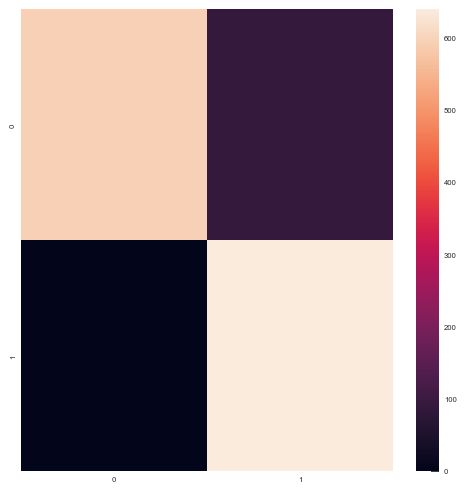

In [246]:
sns.heatmap(C, )

After observing the functional and nonfunctional car engine sound we can see a slight difference:<br>
Nonfunctional engines have a more erratic plots, but it's not clear cut.

# Task 2: explore statistics

In this task you need to plot simple statistics for each class, i. e. calculate `mean`, `median`, `std` and other statistics (of your choice) for each row and then visualize them in such a way, that one can figure out if a distribution of a given statistics differs between class `1` and `-1`.

**Hint:** you can consider [violin plots](https://seaborn.pydata.org/examples/grouped_violinplots.html) or [scatter plot matrix](https://seaborn.pydata.org/examples/scatterplot_matrix.html) helpful.

## Example: median

In [114]:
train["data_median"] = train.filter(like="val_").median(axis=1)
test["data_median"] = test.filter(like="val_").median(axis=1)

In [115]:
train["data_median"]

0      -0.030960
1       0.035526
2       0.076201
3       0.011714
4       0.092380
          ...   
3596    0.010031
3597    0.039984
3598    0.052548
3599   -0.015627
3600   -0.030453
Name: data_median, Length: 3601, dtype: float64

The simplest visualization possible (you need to create smth more elaborated for other features altogether):

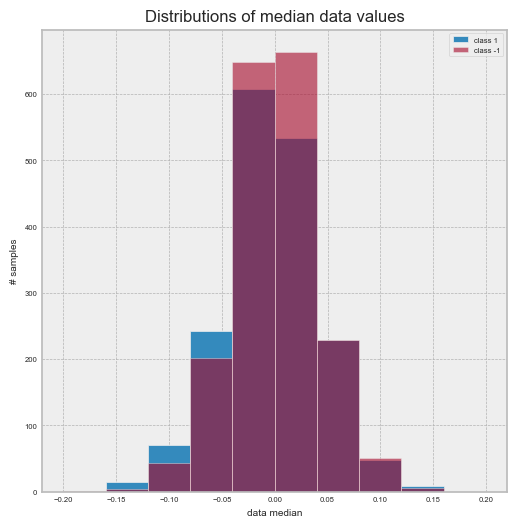

In [116]:
train.loc[train["label"]==1, "data_median"].plot(kind="hist", range=(-0.2, 0.2), label="class 1")
train.loc[train["label"]==-1, "data_median"].plot(kind="hist", range=(-0.2, 0.2), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("data median")
plt.ylabel("# samples")
plt.title("Distributions of median data values", fontsize=12);

**Note:** we can easily check if median is a good feature with ROC curve and score (as they do not rely on any specific normalization of the "predicted" probabilities). Think on why we're using `-data_median`.

In [117]:
fpr, tpr, thr = roc_curve(train["label"], -train["data_median"])

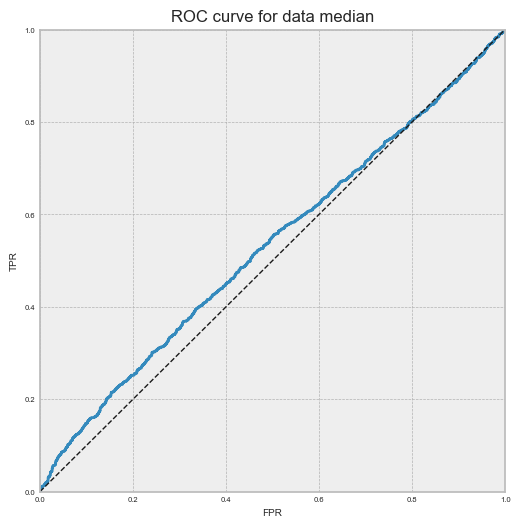

In [118]:
fpr, tpr, thr = roc_curve(train["label"], -train["data_median"])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for data median", fontsize=12);

Ok, median contains *some* information (i. e. looking at median values is better than random classifier), but cannot serve as a *single* feature.

## Exploration

In [119]:
# plot other statistics here - mean, std, skew, max, min, some quantiles
# consider calculating ROC AUC for each feature to perform a preliminary filtering of irrelevant features
# beware of NaNs - some statistics may be broken for some rows

In [120]:
statistics = [('mean', np.mean),('std', np.std),('skew', stats.skew),('max', np.max),('min', np.min)]


for stat in statistics:
    stat_name = "data_" + stat[0]
    train[stat_name] = stat[1](train.filter(like="val_"),axis=1)
    test[stat_name] = stat[1](test.filter(like="val_"),axis=1)

In [121]:
train.filter(like="data_").isna().sum()

data_median    0
data_mean      0
data_std       0
data_skew      0
data_max       0
data_min       0
dtype: int64

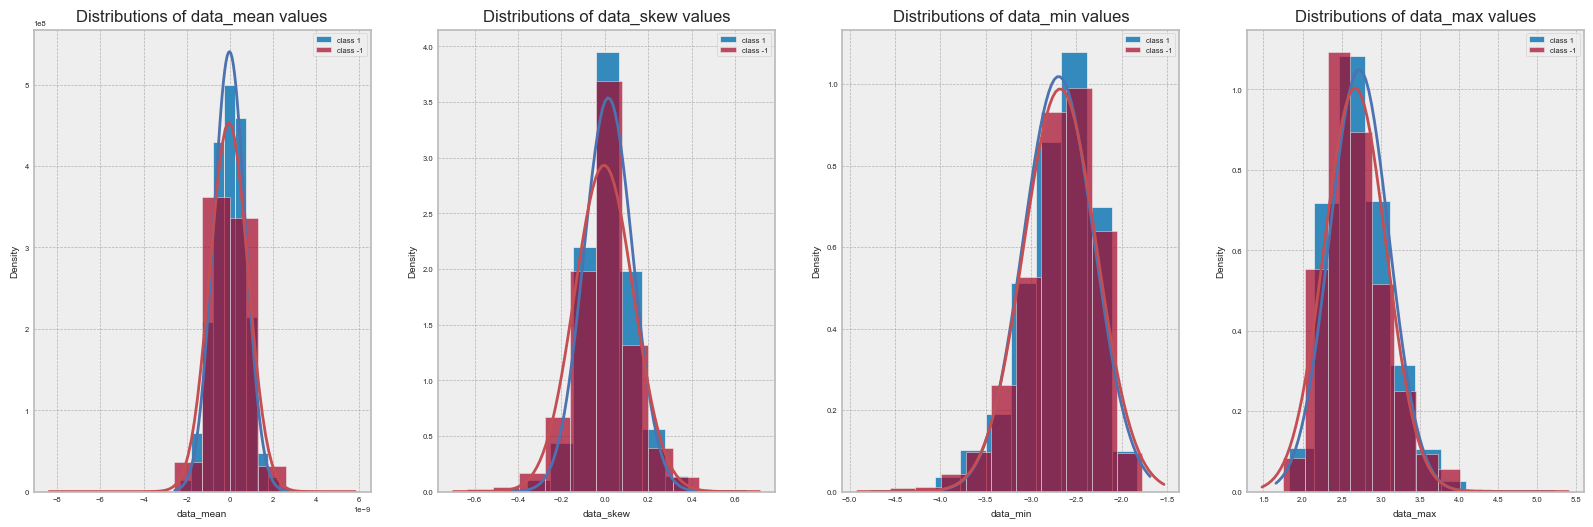

In [122]:
from scipy.stats import norm
statistics = [pd.DataFrame.mean,pd.DataFrame.skew, min, max]
names = ['data_mean','data_skew','data_min','data_max']

plt.figure(figsize=(20,6))
for index, (statistic,name) in enumerate(zip(statistics,names)):
    
# Plot the histogram of the data with a density curve
    train[name] = train.filter(like="val_").apply(statistic,axis=1)
    plt.subplot(1,4,index+1)

    train.loc[train["label"]==1, name].plot(kind="hist", density=True, label="class 1")
    


    
    ## Overlay a bell curve on top of the histogram
    mu, std = train.loc[train["label"]==1, name].mean(), train.loc[train["label"]==1, name].std()
    xmin, xmax = plt.xlim()
    
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, linewidth=2,c='b')


# Plot the histogram of the data with a density curve
    train.loc[train["label"]==-1, name].plot(kind="hist",alpha=0.7, density=True, label="class -1")
    
    ## Overlay a bell curve on top of the histogram
    mu, std = train.loc[train["label"]==-1, name].mean(), train.loc[train["label"]==-1, name].std()
    xmin, xmax = plt.xlim()
    
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, linewidth=2,c='r')

    plt.legend(loc=0)
    plt.xlabel(name)
    plt.ylabel("Density")
    plt.title("Distributions of {} values".format(name), fontsize=12);

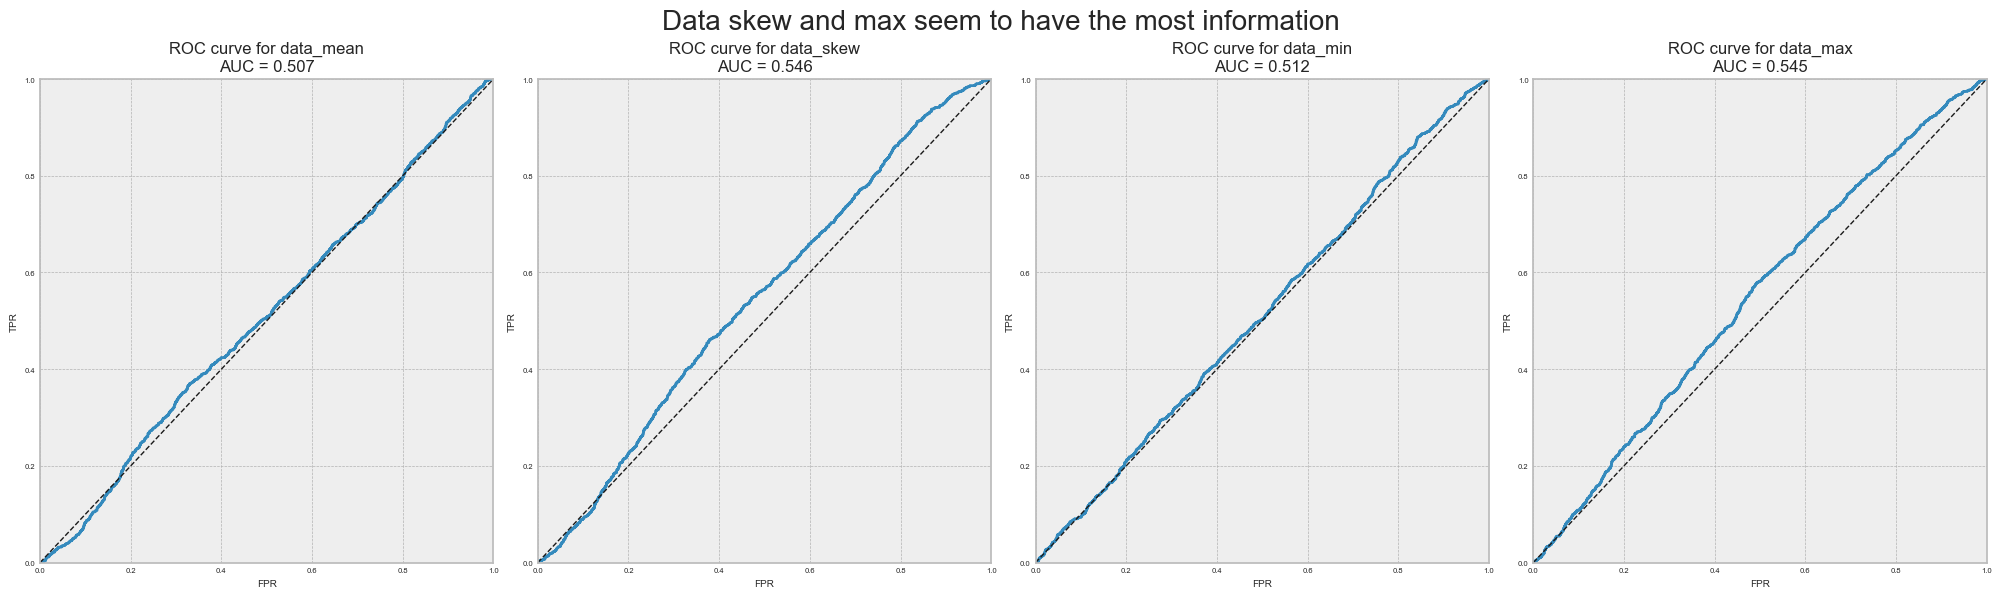

In [124]:
from sklearn.metrics import roc_auc_score
plt.figure(figsize=(20,6))

for index,name in enumerate(names):
    plt.subplot(1,4,index+1)
    if name == "data_min" :
        fpr, tpr, thr = roc_curve(train["label"], -train[name])
        auc = roc_auc_score(train["label"], -train[name])
    else:
        fpr, tpr, thr = roc_curve(train["label"], train[name])
        auc = roc_auc_score(train["label"], train[name])
        
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    
  
    

   
    plt.title("ROC curve for {}\nAUC = {:0.3}".format(name,auc), fontsize=12);
plt.suptitle("Data skew and max seem to have the most information",fontsize=20)

plt.tight_layout()

There is some information in **max** and **skew**

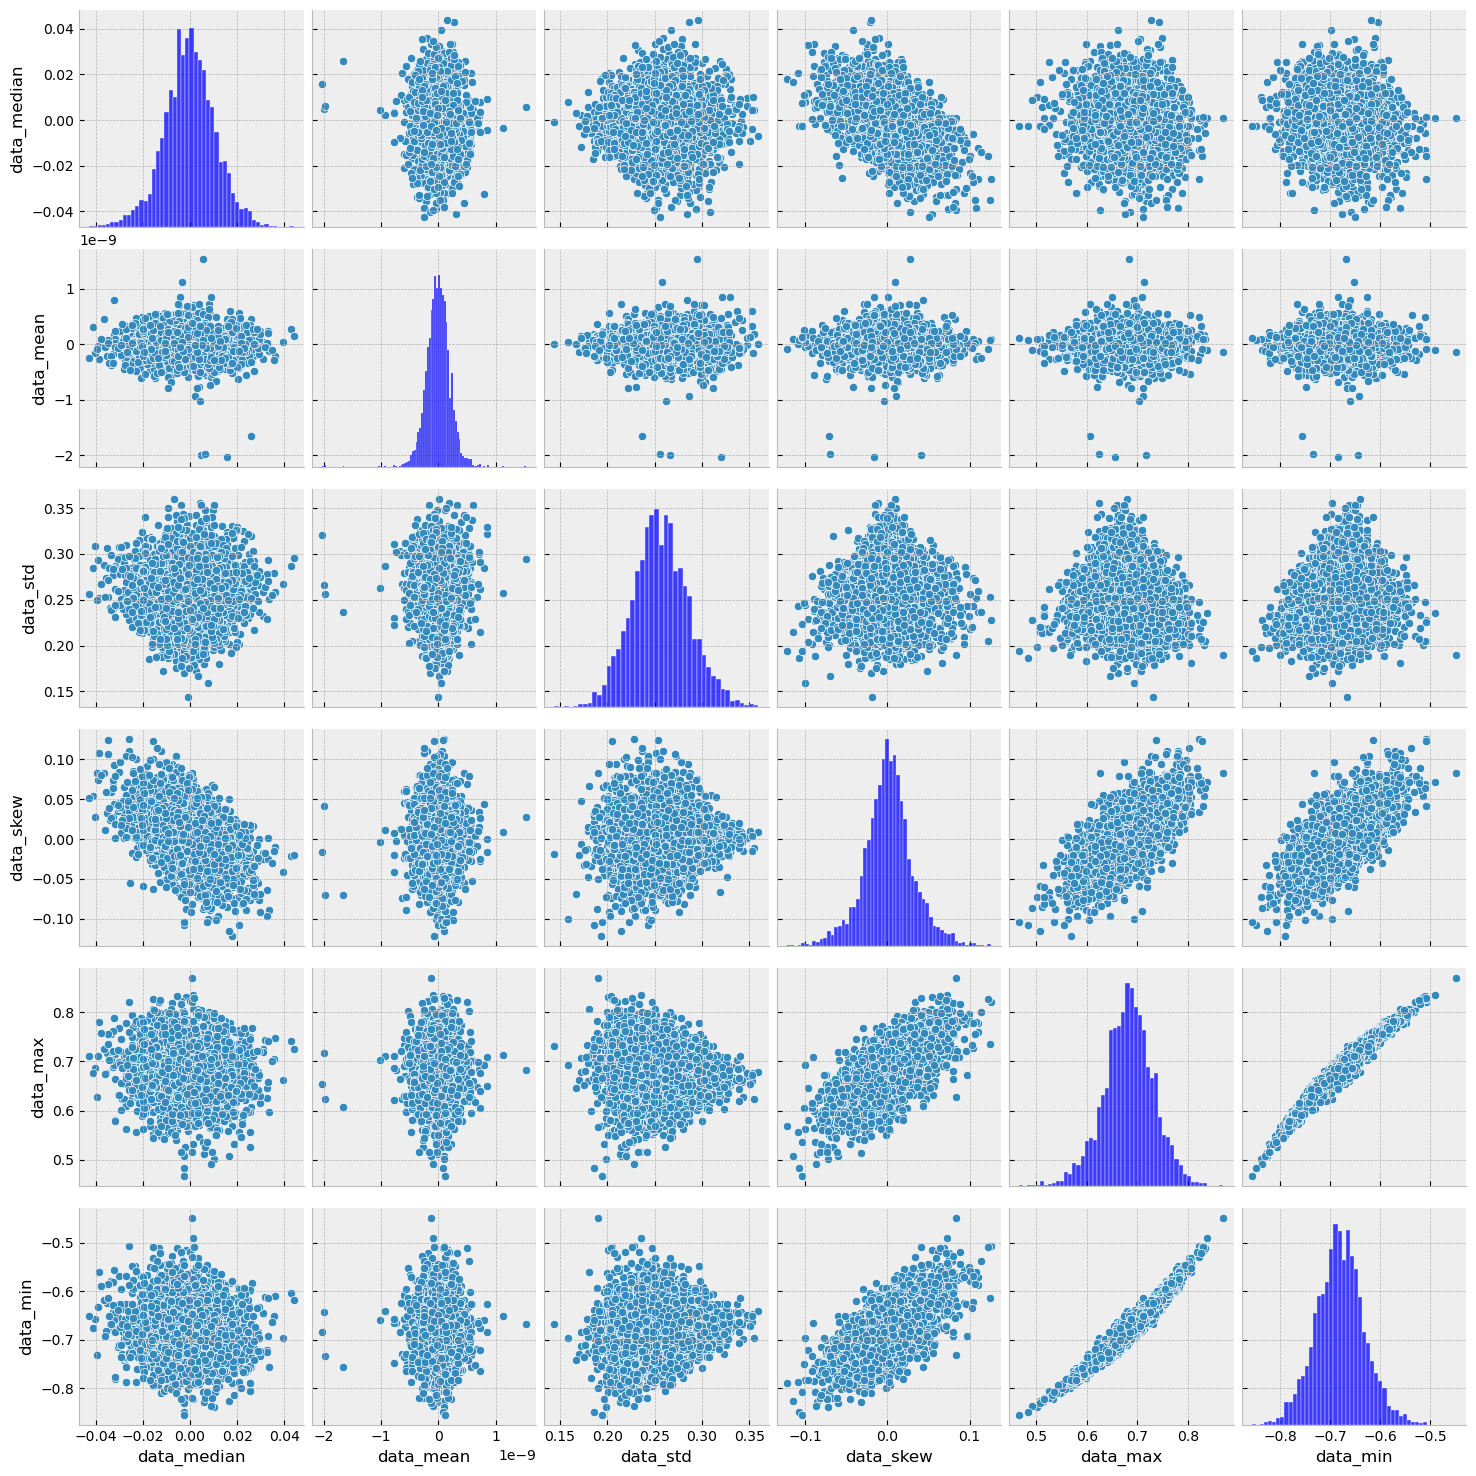

In [29]:
from sklearn.preprocessing import StandardScaler, Normalizer
d = Normalizer().fit_transform(train.filter(like="data_"))
sns.pairplot(pd.DataFrame(d, columns=train.filter(like="data_").columns))

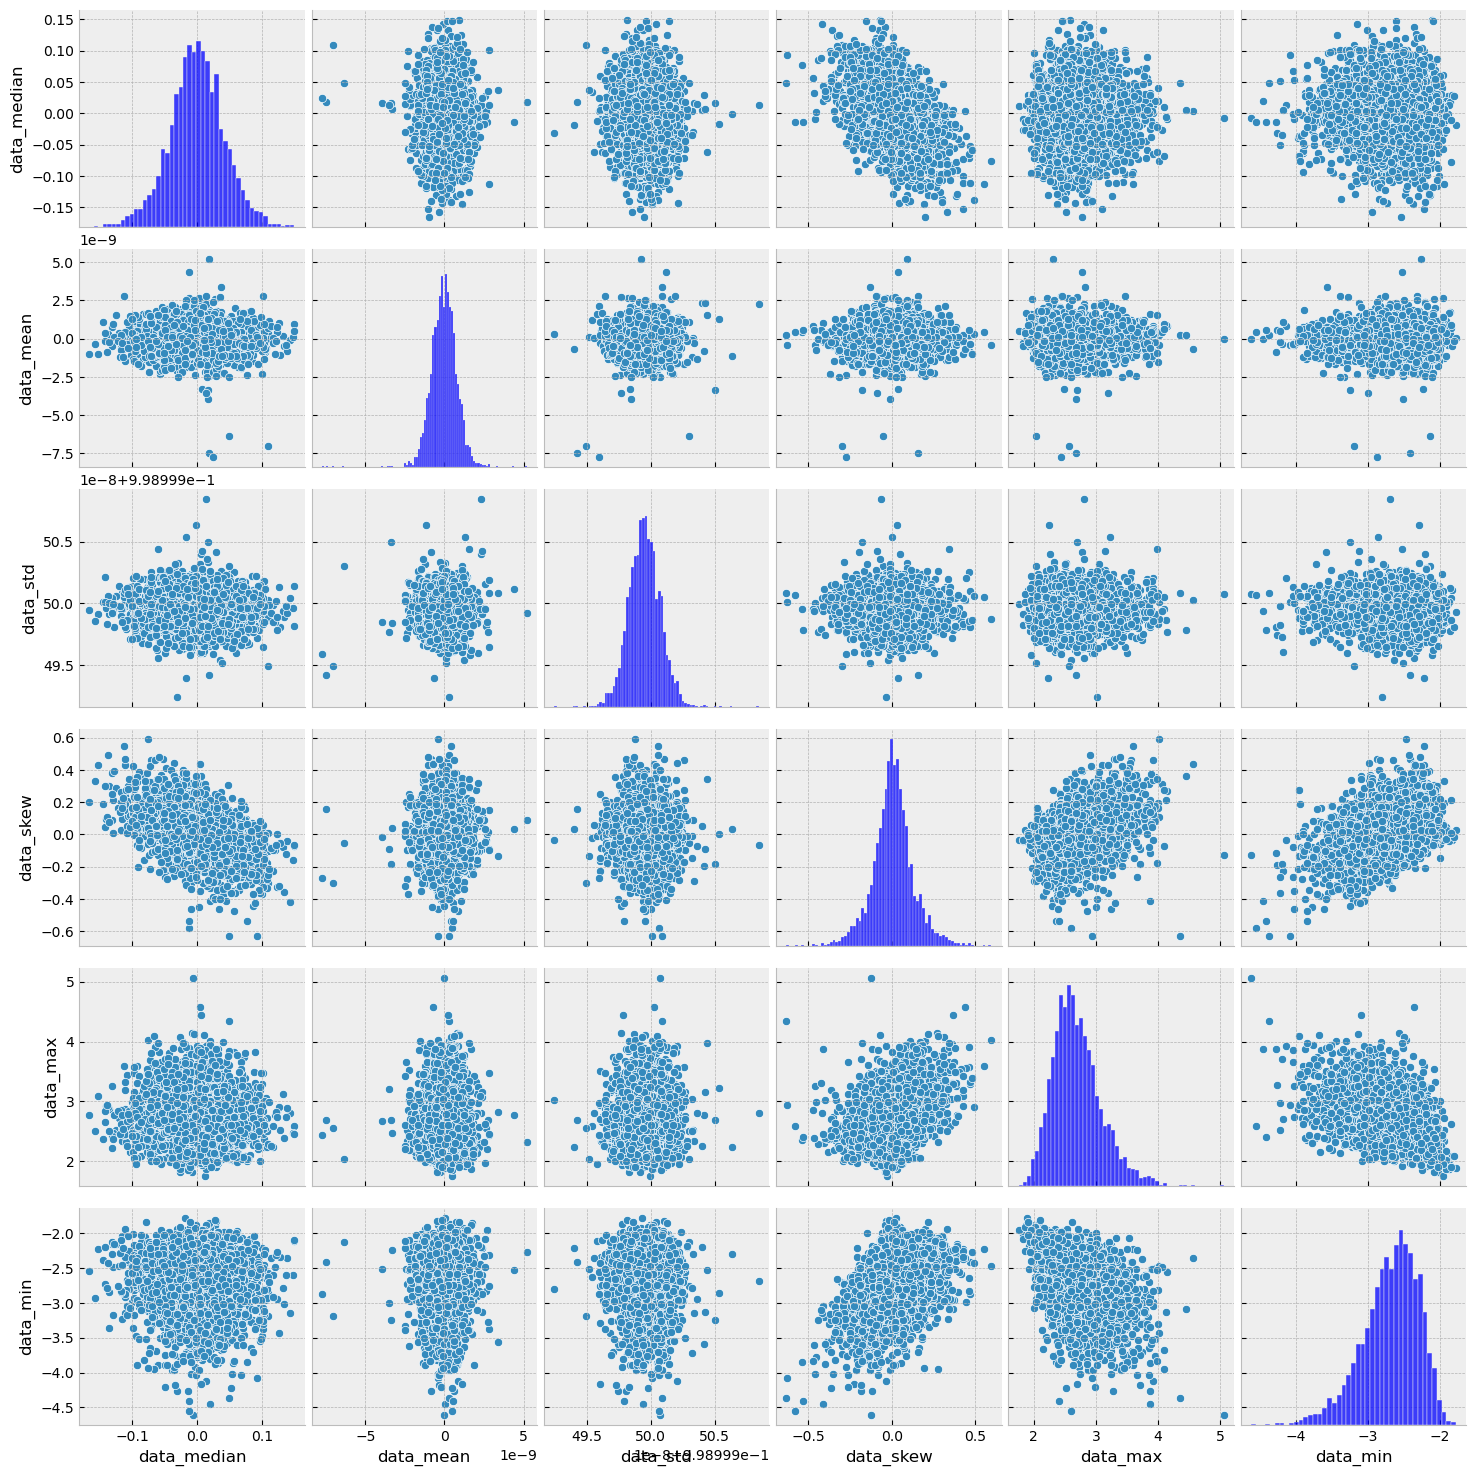

In [30]:
sns.pairplot(train.filter(like="data_"))

Questions:
* when is it appropriate to use **StandardScaler** and when to use **Normalizer**
* After we normalize we got correlation between min max, is it expected hence a bad idea, or does it gives us information?

Observations:
* **min** and **max** us some correlation when we normalize the data.<br>


# Task 3: explore advanced features

In this task you need to calculate and analyze other time series features. looking on the data sample, think on which features in time/frequency domains may be useful for a classification of the dataset.

**Hint:** try various features from [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).

## Example: 0-crossings

For this features we'll not use `tsfresh`, and will do some ninja stuff in Pandas itself:

**Step 1:** mask on `> 0`.

In [37]:
train.index

RangeIndex(start=0, stop=3601, step=1)

In [40]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
unpivot_train = pd.melt(train.filter(like="val_").reset_index(),id_vars = 'index')
unpivot_train.head()
extract_features_arr = extract_features(unpivot_train,column_id  = 'index',column_sort='variable',default_fc_parameters=EfficientFCParameters())

Feature Extraction: 100%|██████████| 20/20 [09:39<00:00, 28.96s/it]


In [41]:
extract_features_arr

value__variance_larger_than_standard_deviation  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
3596                                             0.0   
3597                                             0.0   
3598                                             0.0   
3599                                             0.0   
3600                                             0.0   

      value__has_duplicate_max  value__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
3596                       1.0                       0.0   
3597                       0.0                       0.0   
3598                       0.0                       0.0   
3599                       0.0                       0.0   
3600                       0.0                       0.0   

      value__has_duplicate  value__sum_values  value__abs_energy  \
0                      1.0      -2.831000e-07         499.000001   
1                      0.0      -2.359999e-08         499.000000   
2                      1.0      -1.189290e-06         498.999998   
3                      1.0       4.713900e-07         499.000001   
4                      1.0      -2.094000e-07         499.000001   
...                    ...                ...                ...   
3596                   1.0      -4.682000e-08         499.000000   
3597                   0.0       2.540000e-07         499.000001   
3598                   1.0       1.059000e-07         499.000000   
3599                   0.0      -8.690000e-08         499.000002   
3600                   1.0      -1.253870e-06         498.999999   

      value__mean_abs_change  value__mean_change  \
0                   0.399362            0.003496   
1                   0.354210           -0.004426   
2                   0.379272            0.001873   
3                   0.387902            0.001511   
4                   0.482615            0.001871   
...                      ...                 ...   
3596                0.310803            0.000915   
3597                0.344887           -0.003402   
3598                0.501922           -0.000300   
3599                0.389776           -0.004777   
3600                0.373729            0.000188   

      value__mean_second_derivative_central  value__median  ...  \
0                                 -0.002000      -0.030960  ...   
1                                  0.002778       0.035526  ...   
2                                  0.003349       0.076201  ...   
3                                  0.001157       0.011714  ...   
4                                 -0.001617       0.092380  ...   
...                                     ...            ...  ...   
3596                              -0.000298       0.010031  ...   
3597                              -0.001151       0.039984  ...   
3598                              -0.001820       0.052548  ...   
3599                               0.001733      -0.015627  ...   
3600                              -0.000239      -0.030453  ...   

      value__fourier_entropy__bins_5  value__fourier_entropy__bins_10  \
0                           0.200814                         0.215617   
1                           0.170467                         0.215617   
2                           0.159721                         0.181214   
3                           0.159721                         0.170467   


In [45]:
extract_features_arr_ = extract_features_arr.dropna(axis=1)

In [46]:
extract_features_arr_

value__variance_larger_than_standard_deviation  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
3596                                             0.0   
3597                                             0.0   
3598                                             0.0   
3599                                             0.0   
3600                                             0.0   

      value__has_duplicate_max  value__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
3596                       1.0                       0.0   
3597                       0.0                       0.0   
3598                       0.0                       0.0   
3599                       0.0                       0.0   
3600                       0.0                       0.0   

      value__has_duplicate  value__sum_values  value__abs_energy  \
0                      1.0      -2.831000e-07         499.000001   
1                      0.0      -2.359999e-08         499.000000   
2                      1.0      -1.189290e-06         498.999998   
3                      1.0       4.713900e-07         499.000001   
4                      1.0      -2.094000e-07         499.000001   
...                    ...                ...                ...   
3596                   1.0      -4.682000e-08         499.000000   
3597                   0.0       2.540000e-07         499.000001   
3598                   1.0       1.059000e-07         499.000000   
3599                   0.0      -8.690000e-08         499.000002   
3600                   1.0      -1.253870e-06         498.999999   

      value__mean_abs_change  value__mean_change  \
0                   0.399362            0.003496   
1                   0.354210           -0.004426   
2                   0.379272            0.001873   
3                   0.387902            0.001511   
4                   0.482615            0.001871   
...                      ...                 ...   
3596                0.310803            0.000915   
3597                0.344887           -0.003402   
3598                0.501922           -0.000300   
3599                0.389776           -0.004777   
3600                0.373729            0.000188   

      value__mean_second_derivative_central  value__median  ...  \
0                                 -0.002000      -0.030960  ...   
1                                  0.002778       0.035526  ...   
2                                  0.003349       0.076201  ...   
3                                  0.001157       0.011714  ...   
4                                 -0.001617       0.092380  ...   
...                                     ...            ...  ...   
3596                              -0.000298       0.010031  ...   
3597                              -0.001151       0.039984  ...   
3598                              -0.001820       0.052548  ...   
3599                               0.001733      -0.015627  ...   
3600                              -0.000239      -0.030453  ...   

      value__fourier_entropy__bins_3  value__fourier_entropy__bins_5  \
0                           0.125256                        0.200814   
1                           0.159721                        0.170467   
2                           0.125256                        0.159721   
3                           0.079983                        0.159721   
4    

In [55]:
from tsfresh.feature_selection.relevance import calculate_relevance_table


relevance_table = calculate_relevance_table(extract_features_arr_, train.label)
relevance_table = relevance_table[relevance_table.relevant]
relevance_table.sort_values("p_value", inplace=True)

In [77]:
relevance_table.shape

(237, 4)

In [126]:
relevance_table.head(10).feature.values

array(['value__percentage_of_reoccurring_values_to_all_values',
       'value__ar_coefficient__coeff_7__k_10',
       'value__percentage_of_reoccurring_datapoints_to_all_datapoints',
       'value__has_duplicate',
       'value__ratio_value_number_to_time_series_length',
       'value__autocorrelation__lag_9',
       'value__agg_autocorrelation__f_agg_"median"__maxlag_40',
       'value__partial_autocorrelation__lag_5',
       'value__spkt_welch_density__coeff_5',
       'value__ar_coefficient__coeff_8__k_10'], dtype=object)

In [63]:
top_features_first = relevance_table[:6].feature.values
top_features_second = relevance_table[:6].feature.values

In [74]:
sns.set(font_scale=0.5)

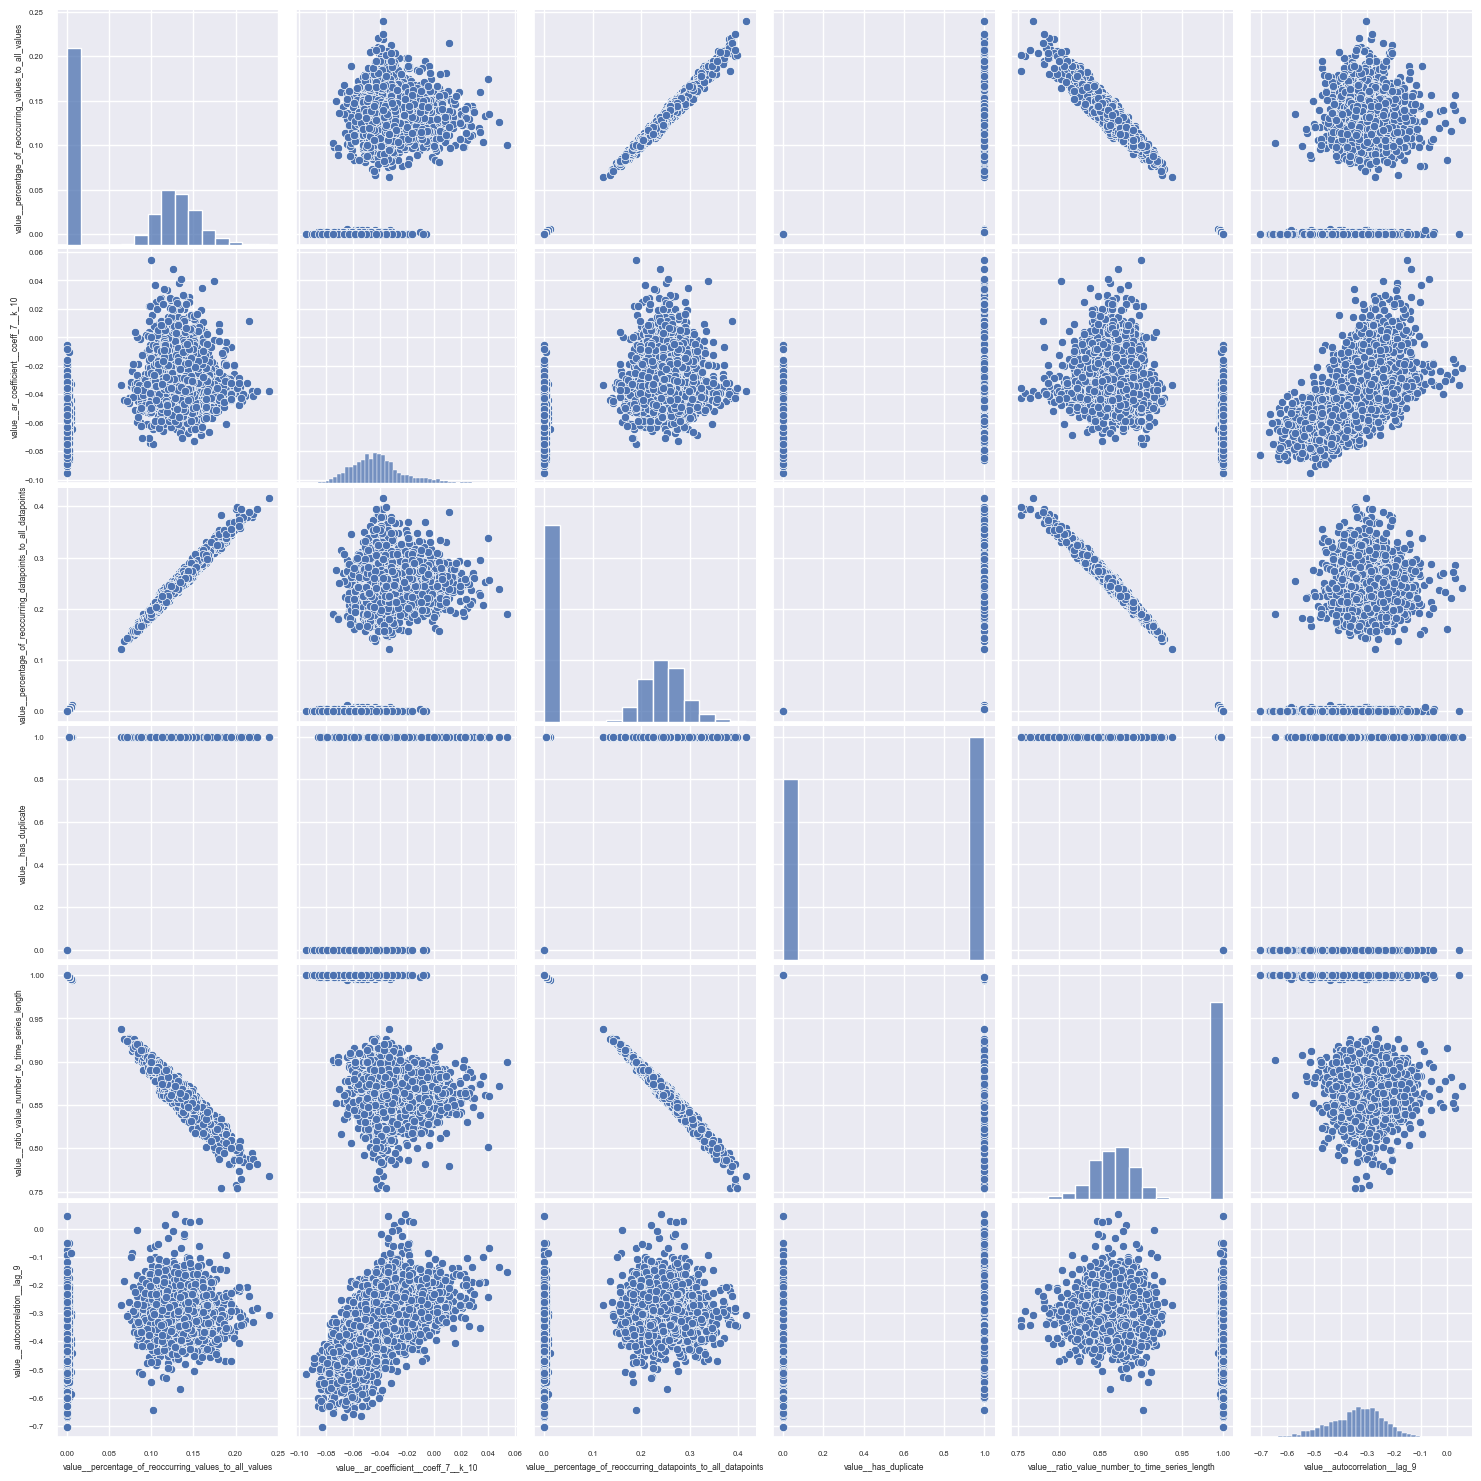

In [75]:
sns.pairplot(extract_features_arr_[top_features_first])

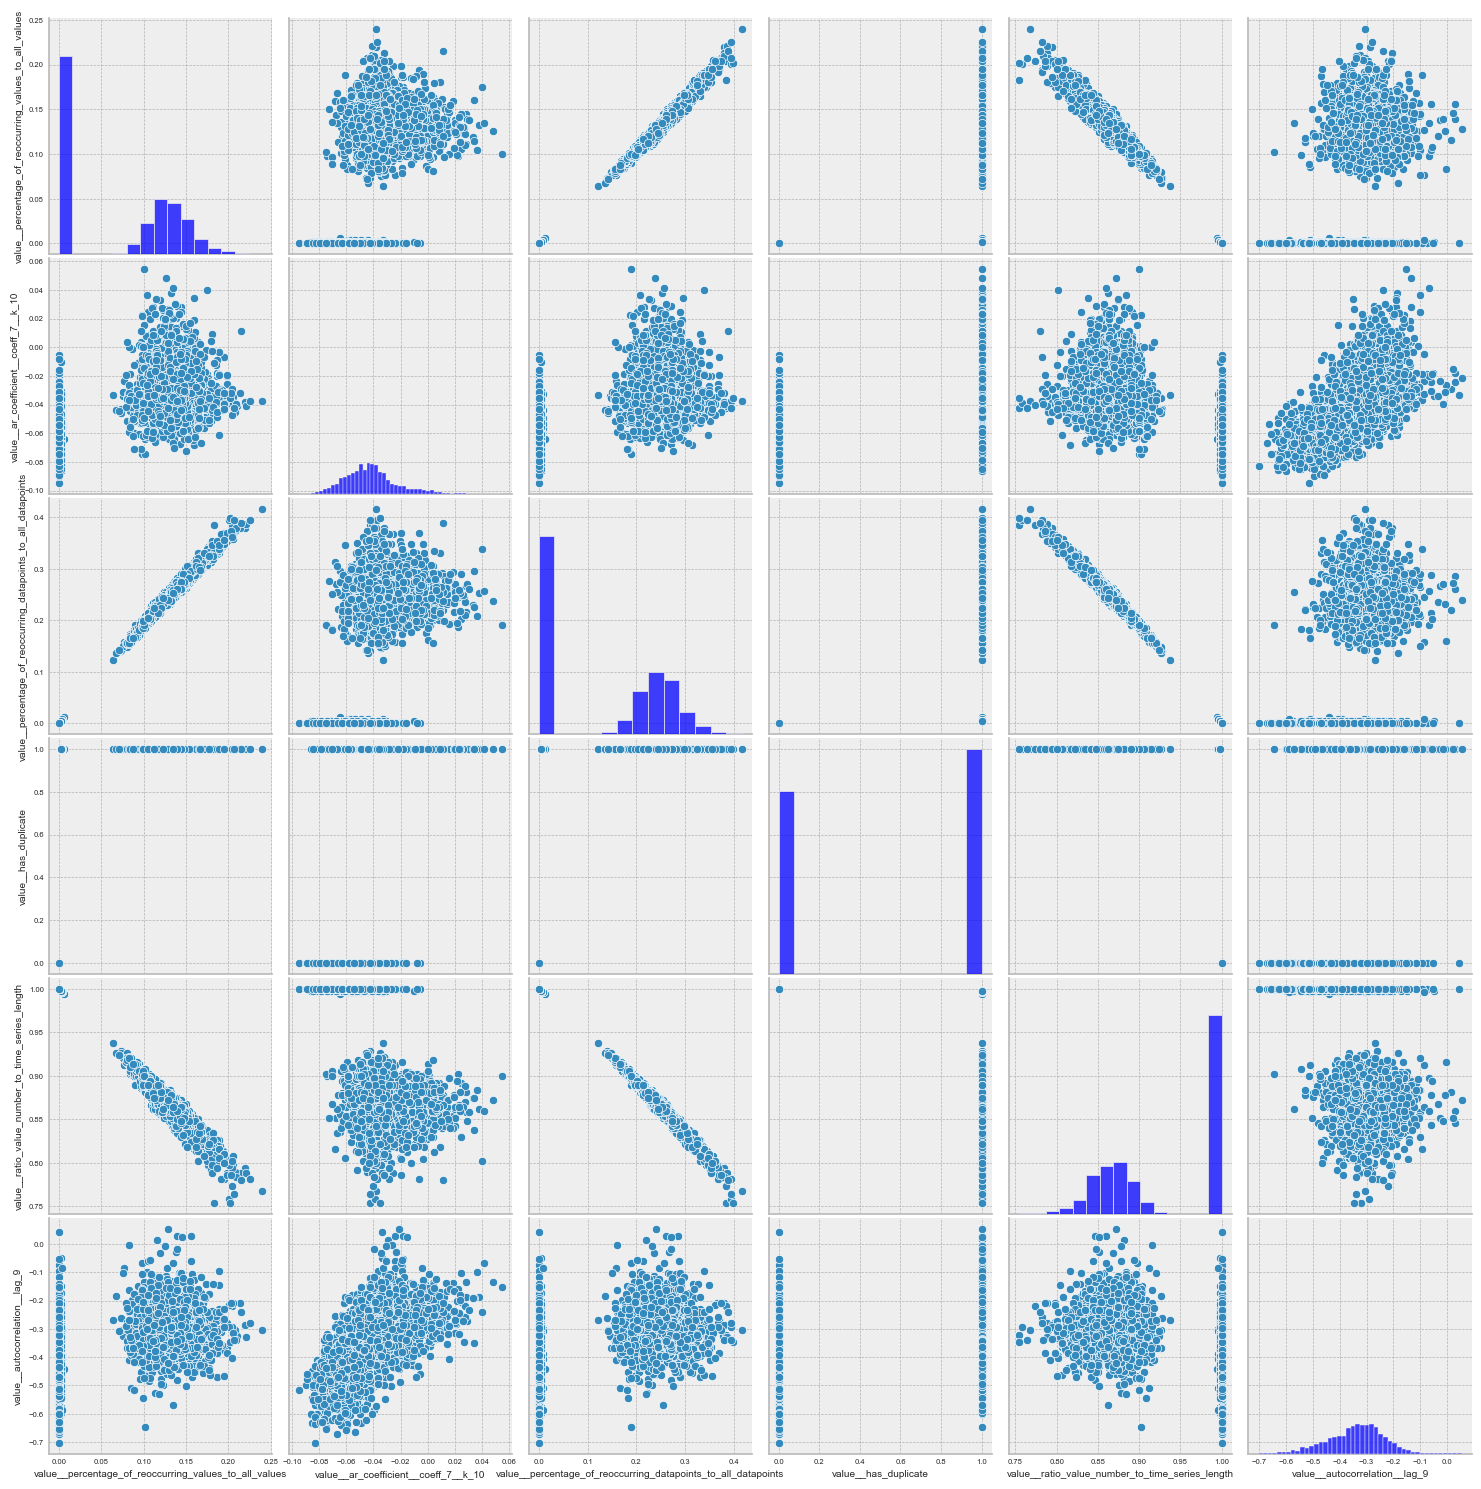

In [125]:
sns.pairplot(extract_features_arr_[top_features_second])

In [78]:
mask = (train.filter(like="val_") > 0).astype(int)
mask

val_1  val_2  val_3  val_4  val_5  val_6  val_7  val_8  val_9  val_10  \
0         0      0      0      1      1      1      1      1      1       1   
1         1      1      1      1      0      0      0      0      0       0   
2         1      1      0      0      0      0      0      0      0       0   
3         0      0      0      0      0      0      0      0      0       0   
4         0      0      1      1      1      1      1      1      1       1   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
3596      1      0      0      0      0      0      0      1      1       1   
3597      1      1      1      1      1      1      1      1      1       1   
3598      0      0      0      0      0      0      0      1      1       1   
3599      1      1      1      1      1      1      1      1      1       1   
3600      0      0      0      0      0      0      0      0      0       0   

      ...  val_491  val_492  val_493  val_494  val_495  val_496  val_497  \
0     ...        1        1        1        1        0        0        0   
1     ...        1        1        0        0        0        0        0   
2     ...        1        1        1        1        1        1        1   
3     ...        0        0        0        0        0        0        0   
4     ...        1        1        1        1        1        1        1   
...   ...      ...      ...      ...      ...      ...      ...      ...   
3596  ...        1        1        1        0        0        0        0   
3597  ...        0        0        0        0        0        0        0   
3598  ...        1        1        1        0        0        0        0   
3599  ...        1        1        1        1        1        0        0   
3600  ...        1        1        1        1        1        1        1   

      val_498  val_499  val_500  
0           0        0        0  
1           0        0        0  
2           1        1        1  
3           0        0        1  
4           1        0        0  
...       ...      ...      ...  
3596        0        0        0  
3597        0        0        0  
3598        0        0        0  
3599        0        0        0  
3600        1        1        1  

[3601 rows x 500 columns]

**Step 2:** calc `diff` to get crossings (from `< 0` to `> 0`, or other way around).

In [79]:
mask.diff(axis=1) == 1  # crossing from -0 to +0

val_1  val_2  val_3  val_4  val_5  val_6  val_7  val_8  val_9  val_10  \
0     False  False  False   True  False  False  False  False  False   False   
1     False  False  False  False  False  False  False  False  False   False   
2     False  False  False  False  False  False  False  False  False   False   
3     False  False  False  False  False  False  False  False  False   False   
4     False  False   True  False  False  False  False  False  False   False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
3596  False  False  False  False  False  False  False   True  False   False   
3597  False  False  False  False  False  False  False  False  False   False   
3598  False  False  False  False  False  False  False   True  False   False   
3599  False  False  False  False  False  False  False  False  False   False   
3600  False  False  False  False  False  False  False  False  False   False   

      ...  val_491  val_492  val_493  val_494  val_495  val_496  val_497  \
0     ...    False    False    False    False    False    False    False   
1     ...    False    False    False    False    False    False    False   
2     ...    False    False    False    False    False    False    False   
3     ...    False    False    False    False    False    False    False   
4     ...    False    False    False    False    False    False    False   
...   ...      ...      ...      ...      ...      ...      ...      ...   
3596  ...    False    False    False    False    False    False    False   
3597  ...    False    False    False    False    False    False    False   
3598  ...    False    False    False    False    False    False    False   
3599  ...    False    False    False    False    False    False    False   
3600  ...     True    False    False    False    False    False    False   

      val_498  val_499  val_500  
0       False    False    False  
1       False    False    False  
2       False    False    False  
3       False    False     True  
4       False    False    False  
...       ...      ...      ...  
3596    False    False    False  
3597    False    False    False  
3598    False    False    False  
3599    False    False    False  
3600    False    False    False  

[3601 rows x 500 columns]

In [80]:
mask.diff(axis=1) == -1  # crossing from +0 to -0

val_1  val_2  val_3  val_4  val_5  val_6  val_7  val_8  val_9  val_10  \
0     False  False  False  False  False  False  False  False  False   False   
1     False  False  False  False   True  False  False  False  False   False   
2     False  False   True  False  False  False  False  False  False   False   
3     False  False  False  False  False  False  False  False  False   False   
4     False  False  False  False  False  False  False  False  False   False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
3596  False   True  False  False  False  False  False  False  False   False   
3597  False  False  False  False  False  False  False  False  False   False   
3598  False  False  False  False  False  False  False  False  False   False   
3599  False  False  False  False  False  False  False  False  False   False   
3600  False  False  False  False  False  False  False  False  False   False   

      ...  val_491  val_492  val_493  val_494  val_495  val_496  val_497  \
0     ...    False    False    False    False     True    False    False   
1     ...    False    False     True    False    False    False    False   
2     ...    False    False    False    False    False    False    False   
3     ...    False    False    False    False    False    False    False   
4     ...    False    False    False    False    False    False    False   
...   ...      ...      ...      ...      ...      ...      ...      ...   
3596  ...    False    False    False     True    False    False    False   
3597  ...    False    False    False    False    False    False    False   
3598  ...    False    False    False     True    False    False    False   
3599  ...    False    False    False    False    False     True    False   
3600  ...    False    False    False    False    False    False    False   

      val_498  val_499  val_500  
0       False    False    False  
1       False    False    False  
2       False    False    False  
3       False    False    False  
4       False     True    False  
...       ...      ...      ...  
3596    False    False    False  
3597    False    False    False  
3598    False    False    False  
3599    False    False    False  
3600    False    False    False  

[3601 rows x 500 columns]

**Step 3:** calculate counts.

In [81]:
train["zero+"] = (mask.diff(axis=1) == 1).sum(axis=1)
train["zero-"] = (mask.diff(axis=1) == -1).sum(axis=1)

In [82]:
train["zero+"]

0       18
1       19
2       17
3       22
4       34
        ..
3596    21
3597    21
3598    32
3599    21
3600    20
Name: zero+, Length: 3601, dtype: int64

**Note:** we do not need to perform any normalization, as all samples have the same length.

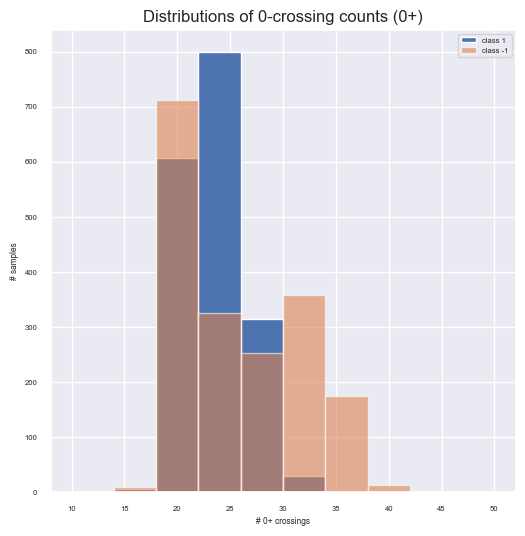

In [83]:
train.loc[train["label"]==1, "zero+"].plot(kind="hist", range=(10, 50), label="class 1")
train.loc[train["label"]==-1, "zero+"].plot(kind="hist", range=(10, 50), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# 0+ crossings")
plt.ylabel("# samples")
plt.title("Distributions of 0-crossing counts (0+)", fontsize=12);

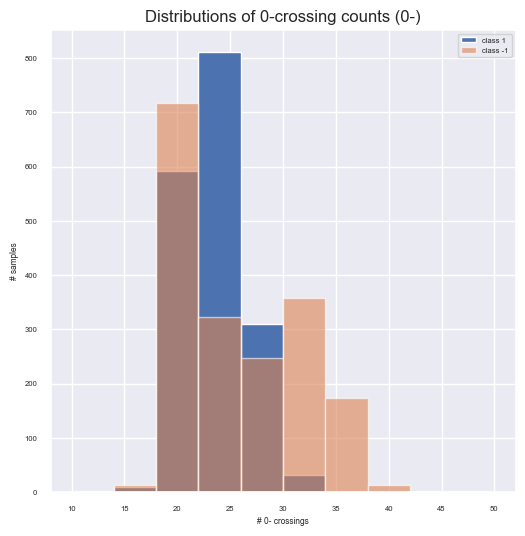

In [84]:
train.loc[train["label"]==1, "zero-"].plot(kind="hist", range=(10, 50), label="class 1")
train.loc[train["label"]==-1, "zero-"].plot(kind="hist", range=(10, 50), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# 0- crossings")
plt.ylabel("# samples")
plt.title("Distributions of 0-crossing counts (0-)", fontsize=12);

Of course, for oscillatory time series `zero+` and `zero-` are highly correlated, so we may drop one of them:

In [85]:
train.filter(like="zero").corr()

zero+     zero-
zero+  1.000000  0.988801
zero-  0.988801  1.000000

In [86]:
train.drop("zero-", axis=1, inplace=True)

The distribution of `zero+` looks fancy, and ROC curve reflects that:

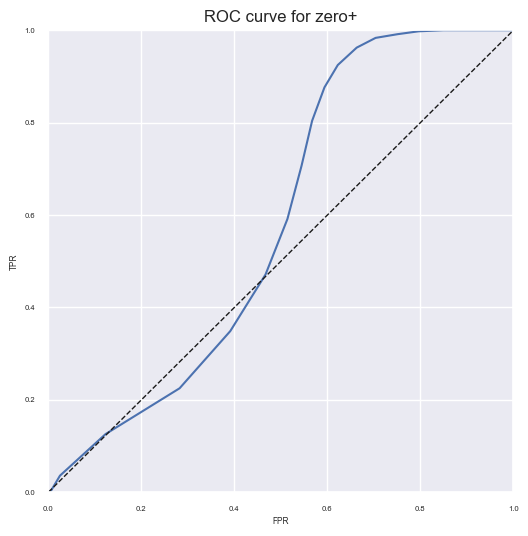

In [87]:
fpr, tpr, thr = roc_curve(train["label"], -train["zero+"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for zero+", fontsize=12);

Think on this in the following way.

Look at the histograms, and perform an estimate (no code, just in your head): given, that `zero+` is equal to `v`, what is the probability of a sample to belong to class `1`? Is this probability monotonic with `v`? How does this influence the choice of the model? Will logistic regression do the job here?

## Exploration

In [ ]:
# plot other features here - you may find various spectral features helpful here
# perform an analysis similar to one we did with number of 0-crossings
# beware of NaNs - some statistics may be broken for some rows

# Task 4: modeling

Given all the features you selected in Tasks 2 and 3, create a binary  classification model. You need to perform:

- reasonable train/validation split of `train`,
- select a model type (out of those, available in `sklearn`, no need to go for, say, gradient boosting),
- train a model, validate it and calculate the final score (ROC AUC) for the test set.

In [ ]:
# do the train/validation split
# train a model
# check the performance on the test set